<a href="https://colab.research.google.com/github/TinyTinfoil/urban-octo-eureka/blob/main/main3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Dataset from [kaggle](https://www.kaggle.com/mostafaabla/garbage-classification)

## Import TensorFlow and other libraries

In [ ]:
#!pip install tf-nightly==2.5.0.dev20210302
#!pip install tensorflow_addons
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential
print(tf.__version__)

2.4.1


## Get the data
save the dataset as garbo.zip to the main folder of your Google Drive ...

The actual dataset looks like this  
<sub>this is what it should look like *inside* `garbo.zip`</sub>

```
garbage_classification/
  battery/
  biological/
  brown-glass/
  cardboard/
  clothes/
  green-glass/
  metal/
  paper/
  plastic/
  shoes/
  trash/
  white-glass/
```

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -d /content /content/gdrive/MyDrive/garbo.zip
#uncomment following lines if you're using your own dataset.
##!unzip /content/dataset-resized.zip
##data_dir = pathlib.Path('/content/dataset-resized')

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/garbage_classification')

This should show 15k images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15515


Sanity Check:

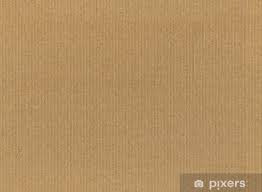

In [ ]:
cardboard = list(data_dir.glob('cardboard/*'))
PIL.Image.open(str(cardboard[0]))

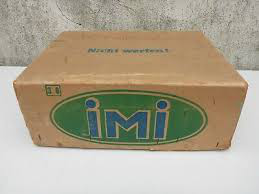

In [ ]:
PIL.Image.open(str(cardboard[1]))

Define some parameters for the data input:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE

['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']


In [ ]:
ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True, seed=123)
ds_size = int(image_count * 0.2)
train_ds = ds.skip(ds_size)
val_ds = ds.take(ds_size)
def num_labler(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  t = parts[-2] == class_names
  return tf.argmax(t)
def img_read(img):
  img = tf.image.decode_jpeg(img,channels=3)
  return tf.keras.preprocessing.image.smart_resize(img,[img_height,img_width])
def smart_map(file_path):
  label = num_labler(file_path)
  img = tf.io.read_file(file_path)
  img = img_read(img)
  return img, label
train_ds = train_ds.map(smart_map,num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(smart_map,num_parallel_calls=AUTOTUNE)
train_ds=train_ds.batch(batch_size,drop_remainder=True)
val_ds=val_ds.batch(batch_size,drop_remainder=True)
print(next(iter(train_ds)))

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[1.50934952e+02, 1.49934952e+02, 1.44934952e+02],
         [1.57660721e+02, 1.56660721e+02, 1.51660721e+02],
         [1.61877548e+02, 1.60877548e+02, 1.55877548e+02],
         ...,
         [1.74107132e+02, 1.71107132e+02, 1.62107132e+02],
         [1.73252594e+02, 1.70252594e+02, 1.61252594e+02],
         [1.75917114e+02, 1.72917114e+02, 1.63917114e+02]],

        [[1.51034439e+02, 1.50034439e+02, 1.45034439e+02],
         [1.62785706e+02, 1.61785706e+02, 1.56785706e+02],
         [1.42130096e+02, 1.41130096e+02, 1.36130096e+02],
         ...,
         [1.74012741e+02, 1.71012741e+02, 1.62012741e+02],
         [1.72417160e+02, 1.69417160e+02, 1.60417160e+02],
         [1.69426025e+02, 1.66426025e+02, 1.57426025e+02]],

        [[1.35811234e+02, 1.34811234e+02, 1.29811234e+02],
         [1.48164536e+02, 1.47164536e+02, 1.42164536e+02],
         [1.47862244e+02, 1.46862244e+02, 1.41862244e+02],
         ...,
         

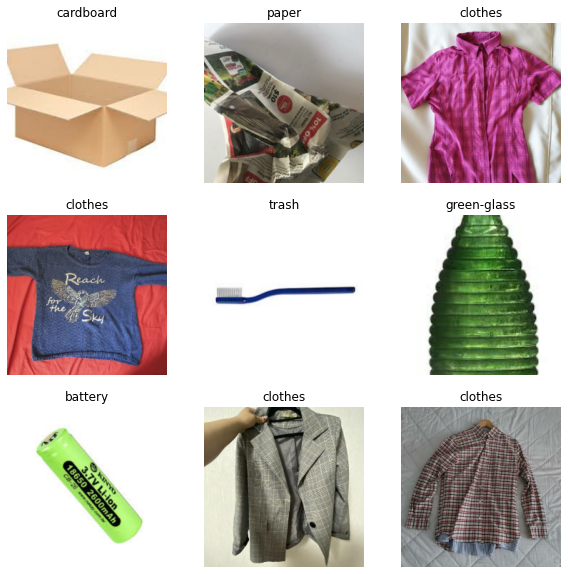

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
base = tf.keras.applications.MobileNetV3Small(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')

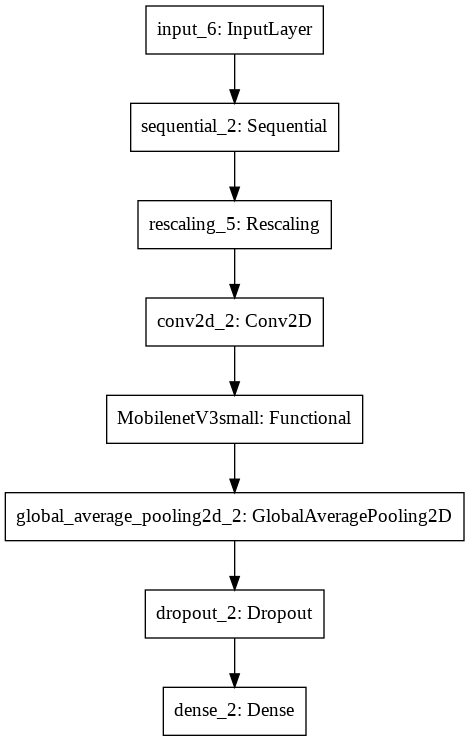

In [ ]:
start = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(start)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(x)
x = tf.keras.layers.Conv2D(3,4,padding='same',activation='relu')(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
end = tf.keras.layers.Dense(num_classes)(x)
model = tf.keras.Model(start, end)
keras.utils.plot_model(model, "model.png")

####Load model weights here (if you want)

In [ ]:
from google.colab import files
model.load_weights(next(iter(files.upload())))

StopIteration: ignored

## Compile and train the model

In [ ]:
base.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)       147       
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0   

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
387/387 [==============================] - 40s 92ms/step - loss: 0.7702 - accuracy: 0.7610 - val_loss: 0.3852 - val_accuracy: 0.8776
Epoch 2/20
387/387 [==============================] - 35s 90ms/step - loss: 0.5039 - accuracy: 0.8365 - val_loss: 0.3927 - val_accuracy: 0.8711
Epoch 3/20
387/387 [==============================] - 35s 90ms/step - loss: 0.4385 - accuracy: 0.8562 - val_loss: 0.3334 - val_accuracy: 0.8936
Epoch 4/20
387/387 [==============================] - 35s 90ms/step - loss: 0.3547 - accuracy: 0.8889 - val_loss: 0.2663 - val_accuracy: 0.9095
Epoch 5/20
387/387 [==============================] - 35s 90ms/step - loss: 0.3086 - accuracy: 0.8962 - val_loss: 0.2274 - val_accuracy: 0.9281
Epoch 6/20
387/387 [==============================] - 35s 91ms/step - loss: 0.2718 - accuracy: 0.9078 - val_loss: 0.1934 - val_accuracy: 0.9329
Epoch 7/20
387/387 [==============================] - 35s 91ms/step - loss: 0.2650 - accuracy: 0.9095 - val_loss: 0.1697 - val_accuracy:

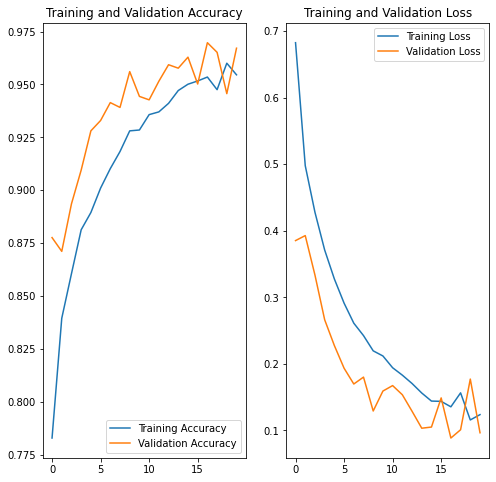

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Fine tuning

In [ ]:
base.trainable = True
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0000001),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)       147       
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0   

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
387/387 [==============================] - 37s 95ms/step - loss: 0.3815 - accuracy: 0.8750 - val_loss: 0.2821 - val_accuracy: 0.9089
Epoch 2/10
387/387 [==============================] - 37s 95ms/step - loss: 0.3724 - accuracy: 0.8787 - val_loss: 0.2707 - val_accuracy: 0.9105
Epoch 3/10
387/387 [==============================] - 36s 94ms/step - loss: 0.3844 - accuracy: 0.8716 - val_loss: 0.2886 - val_accuracy: 0.9111
Epoch 4/10
387/387 [==============================] - 37s 95ms/step - loss: 0.3739 - accuracy: 0.8751 - val_loss: 0.3009 - val_accuracy: 0.9062
Epoch 5/10
387/387 [==============================] - 37s 95ms/step - loss: 0.3783 - accuracy: 0.8766 - val_loss: 0.2873 - val_accuracy: 0.9089
Epoch 6/10
387/387 [==============================] - 37s 95ms/step - loss: 0.3771 - accuracy: 0.8748 - val_loss: 0.3012 - val_accuracy: 0.9010
Epoch 7/10
387/387 [==============================] - 37s 94ms/step - loss: 0.3816 - accuracy: 0.8763 - val_loss: 0.2870 - val_accuracy:

## Predict on new data

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


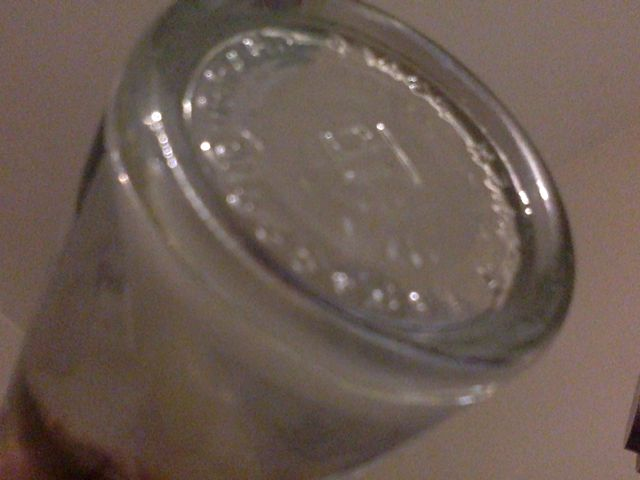

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:

photo_path = "/content/photo.jpg"
img = keras.preprocessing.image.load_img(
    photo_path
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.preprocessing.image.smart_resize(
    img_array,(img_height,img_width), interpolation='bilinear'
)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to white-glass with a 98.57 percent confidence.


##Export Model &#8595;

In [ ]:
from google.colab import files
model.save_weights('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>